In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from scipy.interpolate import UnivariateSpline
%matplotlib inline

The image is of the type  <class 'numpy.ndarray'> with dimensions:  (540, 960, 3)


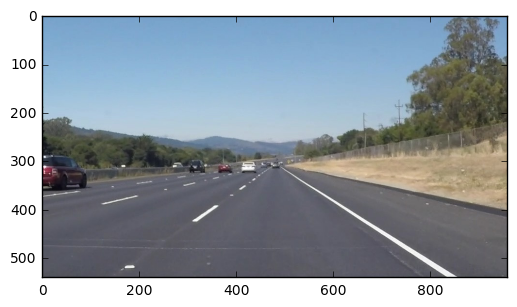

In [6]:
# Reading the image into the notebook
image = mpimg.imread('test_images/solidWhiteRight.jpg')
# Printing out some stats about the image
print ('The image is of the type ', type(image), 'with dimensions: ', image.shape)
plt.imshow(image)

In [40]:
import math
        
def grayscale(img):
    """
    Converts a 3 color channel into grayscale image
    mpimg reads image in RGB format whereas the
    image if read with cv2 is in BGR format so,
    we need to use the appropriate function.
    """
    return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY) # Since initially we read the image using mpimg
    # return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY) # if the image is read using cv2

def region_of_interest(img,vertices):
    """
    Applies an image mask.
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.

    This is done by creating a polygon with the given vertices and then
    filling the polygon with the color white. When a bitwise_and operator is
    applied on the image and the mask then only that part of the image is 
    retained that is desired.

    Example 
    Using region_of_interest function
    vertices = np.array(([0,200],[1000,200],[1000,600],[10,600]))
    vertices = vertices.reshape((-1,1,2))
    plt.imshow(region_of_interest(image,[vertices]))
    
    The region of interest typically lies between the mid region of the image to the bottom of the image.
    So while giving vertices its better to keep this point in view.
    """
    

    #defining a blank mask to start with
    mask = np.zeros_like(img)

    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)

    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def equalized_Histogram(img):
    """
    Processes the image for contrast.
    Improves the contrast of the image that is dull.
    It uses a technique called histogram equalization
    """
    return cv2.equalizeHist(img)

def gaussian_blur(img,kernel_size):
    """
    Applies a Gaussian Noise Kernel.
    The kernel_size has to be an odd number
    The output is a blurred image with reduced noise
    Changing the kernel size reduces or increases the noise but there is also a trade off. 
    """
    return cv2.GaussianBlur(img,(kernel_size,kernel_size),0)

def adaptiveThreshold(img,maxValue,adaptiveMethod,thresholdType,blockSize,C):
    """
    src – Source 8-bit single-channel image.
    maxValue – Non-zero value assigned to the pixels for which the condition is satisfied. See the details below.
    adaptiveMethod – Adaptive thresholding algorithm to use, ADAPTIVE_THRESH_MEAN_C or ADAPTIVE_THRESH_GAUSSIAN_C .
    thresholdType – Thresholding type that must be either THRESH_BINARY or THRESH_BINARY_INV .
    blockSize – Size of a pixel neighborhood that is used to calculate a threshold value for the pixel: 3, 5, 7, and so on.
    C – Constant subtracted from the mean or weighted mean (see the details below). Normally, it is positive but may be zero or negative as well.
    """
    return cv2.adaptiveThreshold(img,maxValue,adaptiveMethod,thresholdType,blockSize,C)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)
    
def draw_extrapolated_lines(img, lines, color=[255, 0, 0], thickness=6):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  

    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.

    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    """
    To Understand the below code look in One Note
    """
    image_shape = img.shape
    
    y_max = image_shape[0]
    y_min = image_shape[0] # We start with this value and slowly revise it. We will extrapolate the like till the y-min
    
    left_slopes = []
    left_x_values = []
    left_y_values = []
    
    right_slopes = []
    right_x_values = []
    right_y_values = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope,intercept = np.polyfit((x1,x2),(y1,y2),1)
            y_min = min(min(y1,y2),y_min)
            if slope < -0.4:
                left_slopes.append(slope)
                left_x_values += ([x1,x2])
                left_y_values += ([y1,y2])
            elif slope > 0.4:
                right_slopes.append(slope)
                right_x_values += ([x1,x2])
                right_y_values += ([y1,y2])

    left_mean_slope = np.mean(left_slopes)
    left_mean_x = np.mean(left_x_values)
    left_mean_y = np.mean(left_y_values)
    left_intercept = left_mean_y - (left_mean_slope*left_mean_x)
    
    right_mean_slope = np.mean(right_slopes)
    right_mean_x = np.mean(right_x_values)
    right_mean_y = np.mean(right_y_values)
    right_intercept = right_mean_y - (right_mean_slope*right_mean_x)
    
    lower_left_point = (int((y_max - left_intercept)/left_mean_slope),y_max)
    upper_left_point = (int((y_min - left_intercept)/left_mean_slope),y_min)
    
    lower_right_point = (int((y_max - right_intercept)/right_mean_slope),y_max)
    upper_right_point = (int((y_min - right_intercept)/right_mean_slope),y_min)
    
    print (lower_left_point)
    
    cv2.line(img, lower_left_point,upper_left_point,color, thickness)
    cv2.line(img, lower_right_point, upper_right_point,color, thickness)
        
    return img

def draw_lines(img, lines, color=[255, 0, 0], thickness=4):
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.

    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, 
                            maxLineGap=max_line_gap)
    """
    The lines files is of the shape (n,1,4) - where 4 represents points [x1,y1,x2,y2]. 
    Line is drawn from (x1,y1) to (x2,y2)
    """
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    """
    line_img generates a black screen the size of the original image. Now Hough lines are drawn on this
    We need to use the weighted_img function to superimpose this image on the original image
    """
    #draw_lines(line_img, lines)
    return line_img , lines

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.

    `initial_img` should be the image before any processing.

    The result image is computed as follows:

    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)


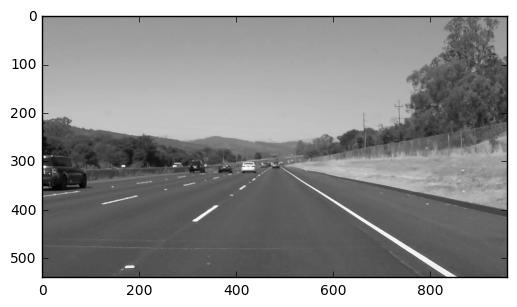

In [8]:
# Converting the region of interest to grayscale
gray = grayscale(image)
plt.imshow(gray, cmap= 'gray')

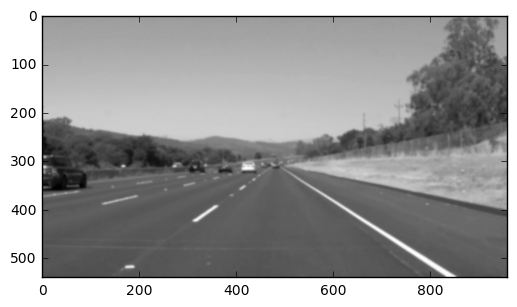

In [9]:
# Applying Gaussian_blur on the grayscaled image
blur = gaussian_blur(gray,9)
plt.imshow(blur, cmap = 'gray')

"\nplt.subplot(121),plt.imshow(gray,cmap = 'gray')\nplt.title('Original Image'), plt.xticks([]), plt.yticks([])\nplt.subplot(122),plt.imshow(cannyEdge,cmap = 'gray')\nplt.title('Edge Image'), plt.xticks([]), plt.yticks([])\nplt.show()\n"

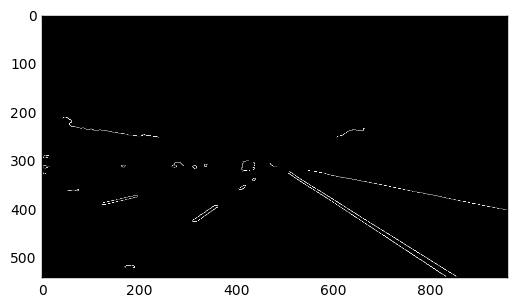

In [10]:
# Trying Canny edge Detection
cannyEdge = canny(blur,120,200)
plt.imshow(cannyEdge, cmap = 'gray')

"""
plt.subplot(121),plt.imshow(gray,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(cannyEdge,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()
"""

'\nvertices = np.array(([0,400],[1280,400],[1280,730],[0,730]))\nvertices = vertices.reshape((-1,1,2))\nroi = region_of_interest(image,[vertices])\nplt.imshow(roi)\n'

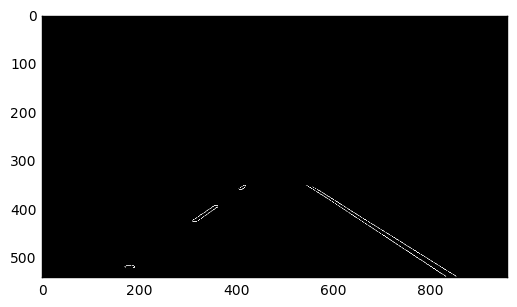

In [11]:
# Finding the Region of Interest

# ROI for test_images 
lower_left_vertex = [120,540]
upper_left_vertex = [400,350]
upper_right_vertex = [550,350]
lower_right_vertex = [900,540]
vertices = np.array((lower_left_vertex,upper_left_vertex,upper_right_vertex,lower_right_vertex))
vertices = vertices.reshape((-1,1,2))
roi_cannyEdge = region_of_interest(cannyEdge,[vertices])
plt.imshow(roi_cannyEdge, cmap = 'gray')

"""
vertices = np.array(([0,400],[1280,400],[1280,730],[0,730]))
vertices = vertices.reshape((-1,1,2))
roi = region_of_interest(image,[vertices])
plt.imshow(roi)
"""

In [41]:
hough_lines_img, lines = hough_lines(img=roi_cannyEdge,rho=1,theta=math.pi/180,threshold = 5,min_line_len=10,max_line_gap=10)
#plt.imshow(hough_lines_img,cmap= 'gray')
#print (lines.shape)

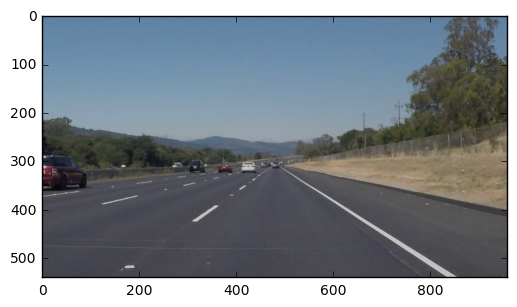

In [22]:
final_image = weighted_img(hough_lines_img,image)
plt.imshow(final_image)

(149, 540)


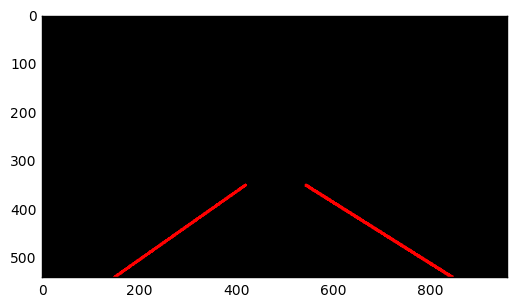

In [42]:
extrapolated_hough_lines_img = draw_extrapolated_lines(hough_lines_img,lines)
plt.imshow(extrapolated_hough_lines_img, cmap = 'gray')

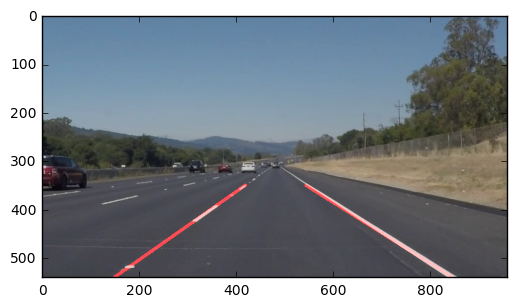

In [43]:
extrapolated_final_image = weighted_img(extrapolated_hough_lines_img,image)
plt.imshow(extrapolated_final_image)

# Creating an Image Processing Pipeline

In [ ]:
def image_pipeline(file,vertices):
    image = mpimg.imread('test_images/'+file)
    roi = region_of_interest(image,[vertices])
    gray = grayscale(roi)
    blur = gaussian_blur(gray,11)
    cannyEdge = canny(blur,120,200)
    hough_lines_img = hough_lines(img=cannyEdge,rho=1,theta=math.pi/180,threshold = 5,min_line_len=10,max_line_gap=10)
    final_image = weighted_img(hough_lines_img,image)
    mpimg.imsave(file,final_image)

In [ ]:
import os
files = os.listdir('test_images/')

In [ ]:
vertices = np.array(([0,300],[960,300],[960,540],[0,540]))
vertices = vertices.reshape((-1,1,2))

for file in files:
    image_pipeline(file,vertices)

# Video Part of the Project Using cv2 - Plays Alright but fails while writing - Next is try using moviepy

In the previous section we did analysis on the image and in this section we would be doing
analysis on the video and construct lines in the video.
Let's Roll

In [ ]:
# Preprocessing Steps
vertices = np.array(([0,300],[960,300],[960,540],[0,540]))
vertices = vertices.reshape((-1,1,2))

# Loading the video using cv2
video = cv2.VideoCapture('solidWhiteRight.mp4')

# Creating an output file for the video
#fourcc = cv2.VideoWriter_fourcc(*'XVID')
#out = cv2.VideoWriter('output.mp4',fourcc,20.0,(540,960))

while(video.isOpened()):
    ret, frame = video.read()
    if frame!= None:
        roi = region_of_interest(frame,[vertices])
        gray = grayscale(roi)
        blur = gaussian_blur(gray,11)
        cannyEdge = canny(blur,120,200)
        hough_lines_img = hough_lines(img=cannyEdge,rho=1,theta=math.pi/180,threshold = 5,min_line_len=10,max_line_gap=10)
        final_image = weighted_img(hough_lines_img,image)
        cv2.imshow('frame',final_image)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Releasing the video
video.release()
#out.release()
cv2.destroyAllWindows()

# Video part using moviepy

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML